## Attempt at data reading optimization

Our team is looking into using the NetFlow events from Los Alamos as the main dataset for our purposes, since the previously provided ATI data lacks in features (eg. Time, Ports, Protocols etc.). However, the data is outstandingly large, so we ought to look into ways of cutting down on it to even make it accessible.

We thought of looking into the Command&Control sessions exclusively to begin with, and see what the data on those only would look like. We made use of [this file](https://github.com/Galeforse/Advanced-Cyber-Analytics-for-Attack-Detection/blob/main/Data/session_hosts.txt), which contains all the C&C session hosts. The chosen procedure was to exclusively read the data having those hosts in place of 'SrcDevices'. The reading power was still limited, so data had to be partitioned:

In [1]:
import pandas as pd
import os 
from dbscan2 import dbscan2
from sklearn.datasets import make_moons
import time
from datetime import datetime
import numpy as np
import gzip

## 1. Memory complexity

We'll first look at how much we can downsize our data memory-wise. This is directly linked to computational power. Time complexity (i.e. time to run) is discussed later in this paper.

In [2]:
pd.options.display.float_format = '{:,}'.format

Here we read the session hosts list:

In [3]:
sh_file = os.getcwd()[:-4] + 'Data\\session_hosts.txt'
rt_sh = list(pd.read_csv(sh_file, header=None)[0])

Here we read a chunk of the data from Day70, and read the first 9mil lines:

In [4]:
path = 'D://LA//NetFlow//'
df_netflow = pd.read_csv(path + 'N70.bz2', header=None, nrows=9000000)

In [5]:
headers = (['Time', 'Duration', 'SrcDevice', 'DstDevice', 'Protocol',
            'SrcPort', 'DstPort', 'SrcPackets', 'DstPackets', 'SrcBytes', 'DstBytes'])
df_netflow.columns = headers

We then deploy the matching procedure:

In [6]:
rt_src_sh = df_netflow[df_netflow['SrcDevice'].isin(rt_sh)]

In [7]:
rt_src_sh

,Time,Duration,SrcDevice,DstDevice,Protocol,SrcPort,DstPort,SrcPackets,DstPackets,SrcBytes,DstBytes
31,5961600,0,Comp700191,Comp960080,6,Port39411,443,34,47,8964,46413
84,5961600,0,Comp939275,Comp275646,17,Port90094,53,1,0,80,0
85,5961600,0,Comp939275,Comp275646,17,Port93126,53,1,0,80,0
86,5961600,0,Comp939275,Comp275646,17,Port18069,53,1,0,80,0
87,5961600,0,Comp939275,Comp275646,17,Port28502,53,1,0,80,0
...,...,...,...,...,...,...,...,...,...,...,...
8998385,5966106,1,Comp953804,Comp607039,6,Port66686,Port34623,0,1,0,46
8998386,5966106,1,Comp953804,Comp607039,6,Port44186,Port17392,0,1,0,46
8998387,5966106,1,Comp953804,Comp607039,6,Port66307,Port37891,0,1,0,46
8999165,5966107,0,Comp679250,Comp576031,17,Port95250,514,1,0,1500,0


We're interested, in percentages, how much we've managed to cut down on data. The result is the following:

In [8]:
print('We are using {} % of the data'.format(rt_src_sh.shape[0]/df_netflow.shape[0]*100))

We are using 3.7448333333333332 % of the data


The result isn't great. We're aiming to a reduction of at least up to 1% of the initial data. 

We'll try the same procedure on Day71, on 9 million lines as well. However, we ought to keep in mind that Day71 is a weekend day:

In [9]:
path = 'D://LA//NetFlow//'
df_netflow = pd.read_csv(path + 'N71.bz2', header=None, nrows=9000000)

In [10]:
headers = (['Time', 'Duration', 'SrcDevice', 'DstDevice', 'Protocol',
            'SrcPort', 'DstPort', 'SrcPackets', 'DstPackets', 'SrcBytes', 'DstBytes'])
df_netflow.columns = headers

In [11]:
rt_src_sh = df_netflow[df_netflow['SrcDevice'].isin(rt_sh)]

In [13]:
rt_src_sh

,Time,Duration,SrcDevice,DstDevice,Protocol,SrcPort,DstPort,SrcPackets,DstPackets,SrcBytes,DstBytes
56,6048000,0,Comp700191,Comp005591,6,Port38876,443,21,25,6786,19902
1482,6048000,1,Comp697805,Comp275646,17,Port54145,53,1,0,60,0
2153,6048000,115,Comp274254,ActiveDirectory,17,Port33855,53,1,1,69,69
2762,6048001,0,Comp511892,Comp576031,17,Port07887,514,1,0,308,0
3598,6048001,1,Comp700191,Comp886995,6,Port78592,443,21,22,7522,13750
...,...,...,...,...,...,...,...,...,...,...,...
8999188,6053433,1,Comp267441,Comp576031,17,Port99160,514,4,0,4923,0
8999363,6053433,2,Comp700191,Comp324742,6,Port25507,Port59938,185,292,22614,339101
8999794,6053434,0,Comp274254,Comp576031,17,Port14258,514,11,0,9445,0
8999858,6053434,0,Comp256041,Comp760873,17,Port72566,427,0,1,0,422


In [14]:
print('We are using {} % of the data'.format(rt_src_sh.shape[0]/df_netflow.shape[0]*100))

We are using 0.4451333333333333 % of the data


Day 71 turned out much better. However, as mentioned, this was to be expected, given it's either a Saturday or Sunday (NetFlow data starts from Day2 so we can't be sure which).

**Implementing DBSCAN**

We cannot hope to visualise on the whole dataset too well, but we can try to implement a form of clustering approach to verify the tendencies of our partitioned data. We'll be using Day71 for that:

In [15]:
# source computers dictionary
src_comps = rt_src_sh['SrcDevice'].unique()
src_comps_dict= {}
for i, key in enumerate(src_comps):
    src_comps_dict[key] = i
    
# destination computers ditionary
dst_comps = rt_src_sh['DstDevice'].unique()
dst_comps_dict= {}
for i, key in enumerate(dst_comps):
    dst_comps_dict[key] = i
    
# source port dictionary
src_port = rt_src_sh['SrcPort'].unique()
src_port_dict= {}
for i, key in enumerate(src_port):
    src_port_dict[key] = i
    
# destination port dictionary
dst_port = rt_src_sh['DstPort'].unique()
dst_port_dict= {}
for i, key in enumerate(dst_port):
    dst_port_dict[key] = i
    
rt_src_sh['SrcDevice'] = rt_src_sh['SrcDevice'].map(src_comps_dict)
rt_src_sh['DstDevice'] = rt_src_sh['DstDevice'].map(dst_comps_dict)
rt_src_sh['SrcPort'] = rt_src_sh['SrcPort'].map(src_port_dict)
rt_src_sh['DstPort'] = rt_src_sh['DstPort'].map(dst_port_dict)

<ipython-input-15-24ddb5661f10>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rt_src_sh['SrcDevice'] = rt_src_sh['SrcDevice'].map(src_comps_dict)
<ipython-input-15-24ddb5661f10>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rt_src_sh['DstDevice'] = rt_src_sh['DstDevice'].map(dst_comps_dict)
<ipython-input-15-24ddb5661f10>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

In [16]:
from sklearn.cluster import DBSCAN
db = DBSCAN(eps=0.1, min_samples=10).fit(rt_src_sh)
labels = db.labels_

no_clusters = len(np.unique(labels) )
no_noise = np.sum(np.array(labels) == -1, axis=0)

print('Estimated no. of clusters: %d' % no_clusters)
print('Estimated no. of noise points: %d' % no_noise)

Estimated no. of clusters: 1
Estimated no. of noise points: 40062


The results are good, estimating a single cluster.

We're left with the major problem of further data reduction. So far, not even the C&C set delivered from our succint observations. A thorough analysis of our attempt can be found [here](https://github.com/Galeforse/Advanced-Cyber-Analytics-for-Attack-Detection/blob/main/Alex/DataRed1.pdf) - where we refer to the 'procedure' as the attempt presented in this paper. The document tackles memory complexity.

## 2. Time complexity/Runtime

We'll now look at what we can draw from the runtime of our procedures. We'll look at 3 different situations: Once we read the data as we normally would, once we use an na_filter which aims at reducing reading time innately, and in the last case we'll tackle the problem of size complexity by only reading 7 of the 11 data features - hopefully reducing time complexity in the process as well.

We make 3 attempts: First on 9 million lines, second on just 1 million, and last on 25 million. The latter presented too much computational force for my device to handle, so thanks to [Gab](https://github.com/Galeforse) for running it for me instead. 

_Attempt 1 - 9 mil. lines_

In [17]:
start_time = datetime.now()
df_netflow = pd.read_csv(path + 'N70.bz2', header=None, nrows=9000000)
end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

start_time = datetime.now()
df_netflow = pd.read_csv(path + 'N70.bz2', header=None, nrows=9000000, na_filter=False)
end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

start_time = datetime.now()
df_netflow = pd.read_csv(path + 'N70.bz2', header=None, nrows=9000000, na_filter=False, usecols=range(0,7))
end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Duration: 0:00:25.837372
Duration: 0:00:23.488007
Duration: 0:00:19.584288


_Attempt 2 - 1 mil. lines_

In [19]:
start_time = datetime.now()
df_netflow = pd.read_csv(path + 'N70.bz2', header=None, nrows=1000000)
end_time = datetime.now()
F1 = end_time - start_time
print('Duration: {}'.format((F1)))

start_time = datetime.now()
df_netflow = pd.read_csv(path + 'N70.bz2', header=None, nrows=1000000, na_filter=False)
end_time = datetime.now()
F2 = end_time - start_time
print('Duration: {}'.format(F2))

start_time = datetime.now()
df_netflow = pd.read_csv(path + 'N70.bz2', header=None, nrows=1000000, na_filter=False, usecols=range(0,7))
end_time = datetime.now()
F3 = end_time - start_time
print('Duration: {}'.format(F3))

Duration: 0:00:02.297687
Duration: 0:00:02.513907
Duration: 0:00:02.463302


_Attempt 3 - 25 mil. lines_

In [ ]:
# start_time = datetime.now()
# df_netflow = pd.read_csv(path + 'N70.bz2', header=None, nrows=25000000)
# end_time = datetime.now()
# F1 = end_time - start_time
# print('Duration: {}'.format((F1)))

# start_time = datetime.now()
# df_netflow = pd.read_csv(path + 'N70.bz2', header=None, nrows=25000000, na_filter=False)
# end_time = datetime.now()
# F2 = end_time - start_time
# print('Duration: {}'.format(F2))

# start_time = datetime.now()
# df_netflow = pd.read_csv(path + 'N70.bz2', header=None, nrows=25000000, na_filter=False, usecols=range(0,7))
# end_time = datetime.now()
# F3 = end_time - start_time
# print('Duration: {}'.format(F3))

Duration: 0:01:57.264834


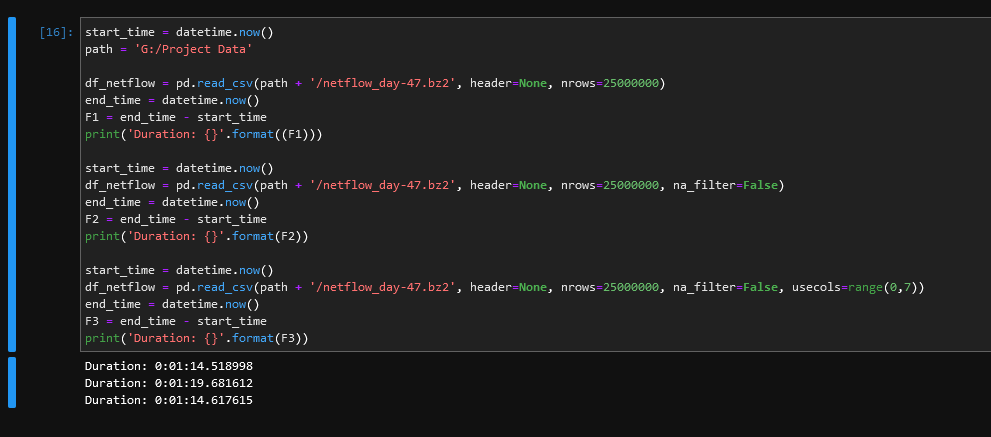

The results became increasingly underwhelming, much like the memory complexity case, as we attempted to read more lines of the dataset. We've also looked into other reading techniques, undocumented here, which were mostly unsuccessfull. 

The mathematical analyis of temporal complexity reduction can be found [here](), similarly to the memory complexity one.

## Conclusions

The results achieved by our team with the NetFlow dataset presented potential of being much more elaborate than the ATI dataset. However, the enormous total size of roughly 1TB is proving itself too difficult to work around. The compressed size of each file can be found [here](https://github.com/Galeforse/Advanced-Cyber-Analytics-for-Attack-Detection/blob/main/Alex/NetFlow/Size.txt), and the average uncompressed size assuming a good observed compression rate of ~15% can be found [here](https://github.com/Galeforse/Advanced-Cyber-Analytics-for-Attack-Detection/blob/main/Alex/NetFlow/AverageSize.txt). The numbers for the compressed sizes are copied [directly from the NetFlow dir](https://csr.lanl.gov/data-fence/1624810951/vDF2KGOyk2BVpCsasFqDIxkbUvA=/unified-host-network-dataset-2017/netflow.html).

As seen in the [memory complexity](https://github.com/Galeforse/Advanced-Cyber-Analytics-for-Attack-Detection/blob/main/Alex/NetFlow/DataRed1.pdf) and [time complexity]() analysis' respectively, our attempts to remediate the costs have been vastly unsuccessful. These concerns, coupled with the difficulty of running models on such large scale and interpret results, led our team to ultimately abandon this path and refocus all our task force on the [ATI Dataset](https://github.com/Galeforse/Advanced-Cyber-Analytics-for-Attack-Detection/tree/main/Data) instead. 

**References**